In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [9]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


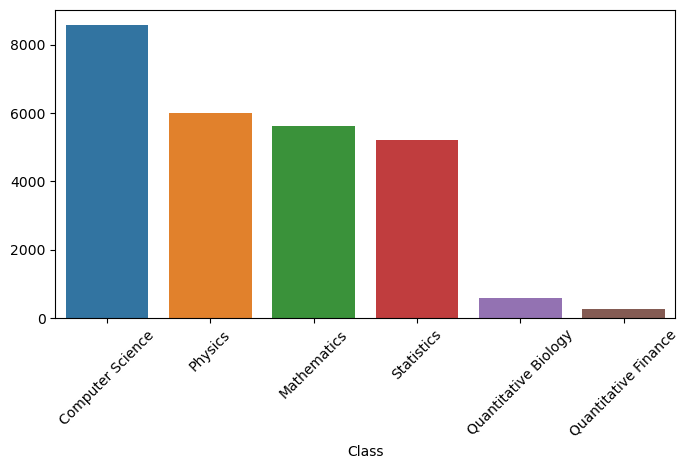

In [4]:
list_classes = train.columns[3:]
count = [(train[column] == 1).sum() for column in list_classes]

plt.figure(figsize=(8,4))
sns.barplot(x=list_classes, y = count)
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()

c:\Users\untu0\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\untu0\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\untu0\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


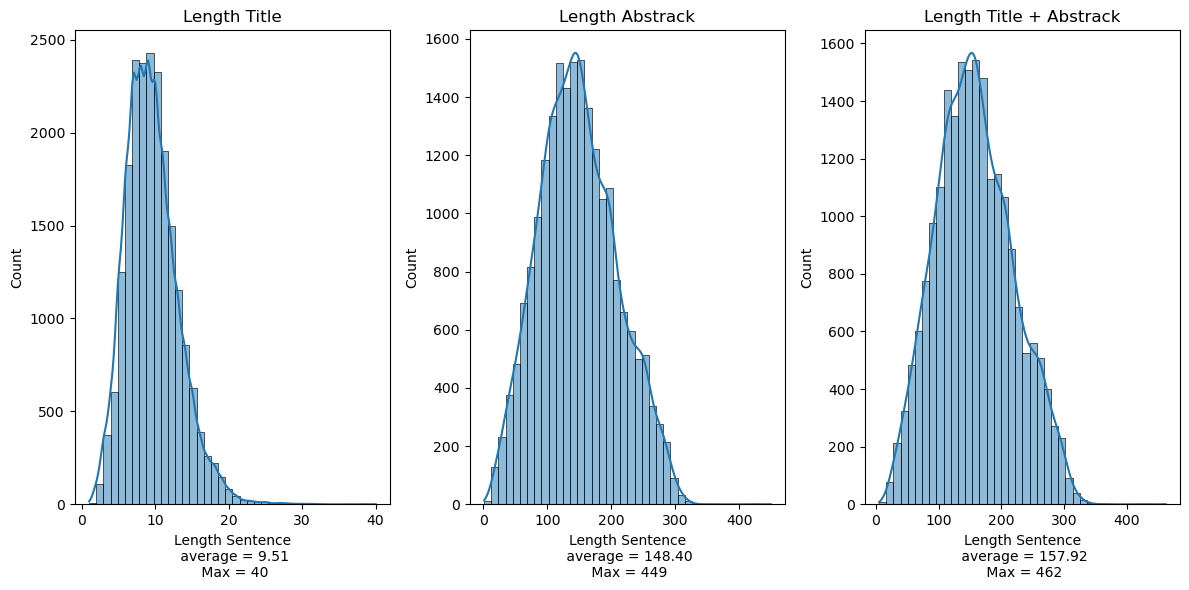

In [5]:
kolom = train.columns[1:3]

length_data_title = [] 
length_data_abstrack = [] 

length_data_title = train['TITLE'].apply(lambda x: len(x.split()))
length_data_abstrack = train['ABSTRACT'].apply(lambda x: len(x.split()))

length_combine = length_data_abstrack+length_data_title

plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
sns.histplot(length_data_title, bins=40, kde = True)
avg = sum(length_data_title)/len(length_data_title)
max_data = length_data_title.max()
plt.title("Length Title")
plt.xlabel(f"Length Sentence\n average = {avg:.2f}\n Max = {max_data}")

plt.subplot(1,3,2)
sns.histplot(length_data_abstrack, bins=40, kde = True)
avg = sum(length_data_abstrack)/len(length_data_abstrack)
max_data = length_data_abstrack.max()
plt.title("Length Abstrack")
plt.xlabel(f"Length Sentence\n average = {avg:.2f}\n Max = {max_data}")

plt.subplot(1,3,3)
sns.histplot(length_combine, bins=40, kde = True)
avg = sum(length_combine)/len(length_combine)
max_data = length_combine.max()
plt.title("Length Title + Abstrack")
plt.xlabel(f"Length Sentence\n average = {avg:.2f}\n Max = {max_data}")


plt.tight_layout()
plt.show()

## stopwords and lematization using NLTK

In [6]:
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
def cleaning_text(text):
    words = text.split()
    words_lemma = [lemma.lemmatize(word) for word in words]
    words_stop = [word for word in words_lemma if word.lower() not in stop_words]
    return words_stop
    

In [7]:
X = train['TITLE'] + train['ABSTRACT']
y = train[list_classes].values

X_test =test['TITLE'] + test['ABSTRACT']

X = X.apply(cleaning_text)
X_test = X_test.apply(cleaning_text)

q80 = int(len(X)*.8)
X_train, y_train = X[:q80], y[:q80]
X_val, y_val = X[q80:], y[q80:]

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer


max_feature = 100_000
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_val_token = tokenizer.texts_to_sequences(X_val)
x_test_token = tokenizer.texts_to_sequences(X_test)


In [9]:
vocabulary = [i for i in enumerate(tokenizer.word_index)]
print("length of vocabulary : ", len(vocabulary))

length of vocabulary :  136205


In [10]:
vocabulary[:10]

[(0, 'model'),
 (1, 'method'),
 (2, 'show'),
 (3, 'data'),
 (4, 'using'),
 (5, 'result'),
 (6, 'network'),
 (7, 'system'),
 (8, 'algorithm'),
 (9, 'problem')]

In [11]:
from keras.utils import pad_sequences
max_length = 500
x_train_pad, x_val_pad, x_test_pad = pad_sequences(X_train_token, maxlen = max_length),pad_sequences(X_val_token, maxlen = max_length),pad_sequences(x_test_token, maxlen = max_length)

## Building Model

In [12]:
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model

input = Input(shape=(max_length,), name= "input")

embed_size = 300 #optimal embed size is 300
x = Embedding(max_feature, embed_size)(input)
x = LSTM(24, return_sequences = True, name = "lstm_layer")(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)


In [13]:
model = Model(inputs=input, outputs=x)
model.summary()
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 300)       │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 500, 24)        │        31,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 24)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,032,198 (114.56 MB)

 Trainable params: 30,032,198 (114.56 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)
history = model.fit(x_train_pad,y_train, batch_size=64, epochs=10, validation_data=(x_val_pad, y_val), callbacks=[callback])

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 130s 482ms/step - accuracy: 0.4039 - loss: 0.4934 - val_accuracy: 0.7769 - val_loss: 0.2689
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 152s 579ms/step - accuracy: 0.7559 - loss: 0.2822 - val_accuracy: 0.7919 - val_loss: 0.2269
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 128s 474ms/step - accuracy: 0.8081 - loss: 0.2113 - val_accuracy: 0.7502 - val_loss: 0.2171
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 116s 441ms/step - accuracy: 0.8144 - loss: 0.1710 - val_accuracy: 0.7182 - val_loss: 0.2189
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 108s 409ms/step - accuracy: 0.8266 - loss: 0.1456 - val_accuracy: 0.7070 - val_loss: 0.2242
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 106s 402ms/step - accuracy: 0.8278 - loss: 0.1276 - val_accuracy: 0.7483 - val_loss: 0.2398
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 105s 399ms/step - accuracy: 0.8346 - loss: 0.1104 - val_accuracy: 0.7468 - val_loss: 0.2564
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 106s 402ms/step - accuracy: 0.8403 -

In [15]:
set(history.history)

{'accuracy', 'loss', 'val_accuracy', 'val_loss'}

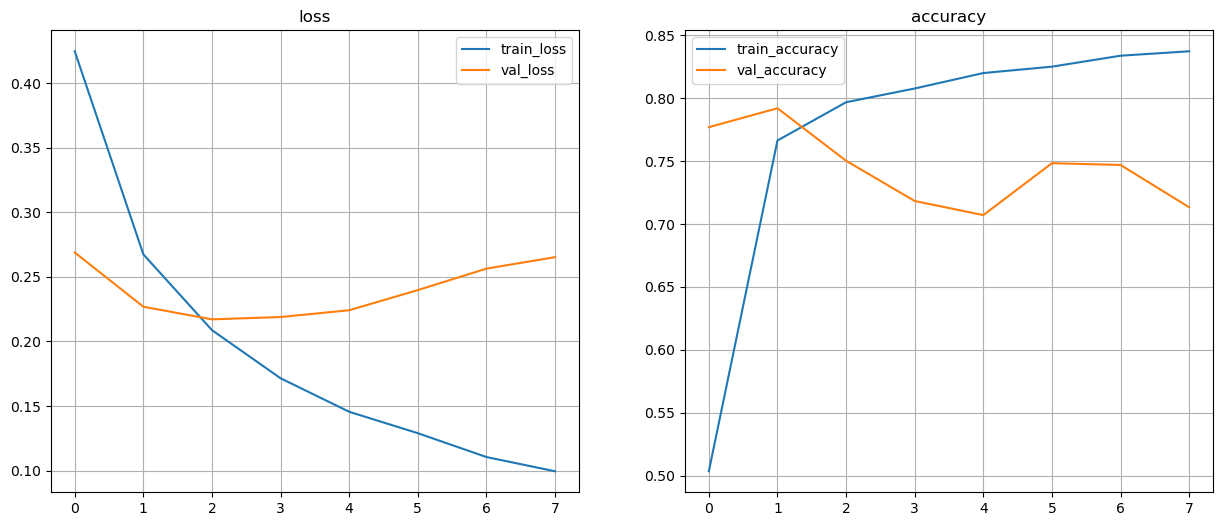

In [16]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title("loss")
plt.plot(range(len(history.history['loss'])), history.history['loss'], label = "train_loss")
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label = "val_loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label = 'train_accuracy')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.grid()
plt.show()

In [17]:
X_test

0       [Closed-form, Marginal, Likelihood, Gamma-Pois...
1       [Laboratory, mid-IR, spectrum, equilibrated, i...
2       [Case, Static, AMSDU, Aggregation, WLANs, Fram...
3       [$Gaia$-ESO, Survey:, inner, disk, intermediat...
4       [Witness-Functions, versus, Interpretation-Fun...
                              ...                        
8984    [Supporting, mixed-datatype, matrix, multiplic...
8985    [axiomatic, basis, Blackwell, optimality, theo...
8986    [GeneVis, -, interactive, visualization, tool,...
8987    [Quantifying, causal, effect, speed, camera, r...
8988    [Cube-magic, labelings, grid, show, vertex, ed...
Length: 8989, dtype: object

In [21]:
prediction = model.predict(x_test_pad)

pred_label = (prediction>=.5).astype(int)

281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step


In [27]:
test.drop(columns='ID', inplace=True)

In [35]:
class_mapping = {
    0: "Computer Science",
    1: "Physics",
    2: "Mathematics",
    3: "Statistics",
    4: "Quantitative Biology",
    5: "Quantitative Finance"
}
def get_predicted_classes(label_vector):
    return ', '.join([class_mapping[i] for i, val in enumerate(label_vector) if val == 1])

result = test.copy()
result['Predicted Classes'] = [get_predicted_classes(label) for label in pred_label]

In [36]:
result

,TITLE,ABSTRACT,Predicted Classes
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Statistics
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Physics
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,"Computer Science, Statistics"
3,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,Physics
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,Computer Science
...,...,...,...
8984,Supporting mixed-datatype matrix multiplicatio...,We approach the problem of implementing mixe...,Computer Science
8985,An axiomatic basis for Blackwell optimality,In the theory of Markov decision processes (...,Mathematics
8986,GeneVis - An interactive visualization tool fo...,GeneVis is a web-based tool to visualize com...,"Computer Science, Statistics"
8987,Quantifying the causal effect of speed cameras...,This paper quantifies the effect of speed ca...,
